Classes: ['NORMAL', 'PNEUMONIA', 'UNKNOWN']
Epoch [1/15] Train Loss: 0.1551 Acc: 0.9374 | Val Loss: 0.5926 Acc: 0.8776
Epoch [2/15] Train Loss: 0.0921 Acc: 0.9681 | Val Loss: 0.4131 Acc: 0.8664
Epoch [3/15] Train Loss: 0.0829 Acc: 0.9744 | Val Loss: 1.0715 Acc: 0.7046
Epoch [4/15] Train Loss: 0.0706 Acc: 0.9732 | Val Loss: 0.0826 Acc: 0.9662
Epoch [5/15] Train Loss: 0.0575 Acc: 0.9780 | Val Loss: 0.1022 Acc: 0.9648
Epoch [6/15] Train Loss: 0.0344 Acc: 0.9880 | Val Loss: 0.0962 Acc: 0.9677
Epoch [7/15] Train Loss: 0.0758 Acc: 0.9708 | Val Loss: 0.1093 Acc: 0.9606
Epoch [8/15] Train Loss: 0.0540 Acc: 0.9792 | Val Loss: 0.0779 Acc: 0.9677
Epoch [9/15] Train Loss: 0.0123 Acc: 0.9976 | Val Loss: 0.0918 Acc: 0.9634
Epoch [10/15] Train Loss: 0.0305 Acc: 0.9892 | Val Loss: 0.0977 Acc: 0.9662
Epoch [11/15] Train Loss: 0.0182 Acc: 0.9928 | Val Loss: 0.0809 Acc: 0.9789
Epoch [12/15] Train Loss: 0.0066 Acc: 0.9976 | Val Loss: 0.1213 Acc: 0.9719
Epoch [13/15] Train Loss: 0.0082 Acc: 0.9967 | Val Lo

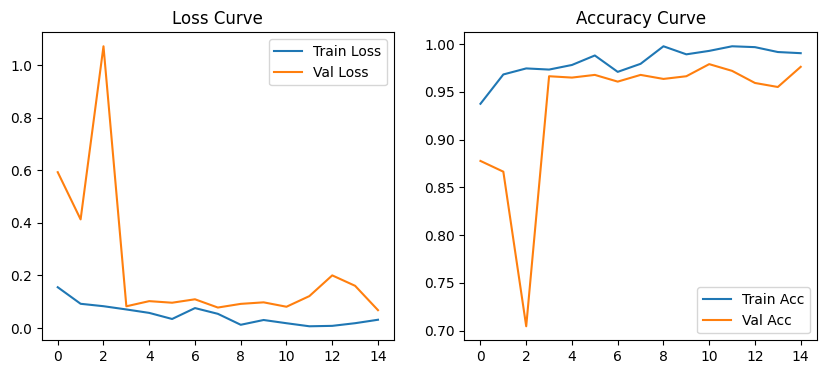

In [5]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# -------------------------------
# CONFIG
# -------------------------------
DATA_DIR = "/kaggle/input/pneumonia-balanced/Balanced"
BATCH_SIZE = 32
EPOCHS = 15
LR = 0.001
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# -------------------------------
# DATASET + TRANSFORMS
# -------------------------------
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406], [0.229,0.224,0.225])
])

train_ds = datasets.ImageFolder(os.path.join(DATA_DIR, "train"), transform=transform)
val_ds   = datasets.ImageFolder(os.path.join(DATA_DIR, "val"), transform=transform)
test_ds  = datasets.ImageFolder(os.path.join(DATA_DIR, "test"), transform=transform)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

classes = train_ds.classes
print("Classes:", classes)

# -------------------------------
# MODEL (ResNet18)
# -------------------------------
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, len(classes))  # 3 classes
model = model.to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

# -------------------------------
# TRAINING LOOP
# -------------------------------
train_acc_history, val_acc_history = [], []
train_loss_history, val_loss_history = [], []

for epoch in range(EPOCHS):
    model.train()
    running_loss, running_corrects = 0.0, 0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
        running_corrects += (outputs.argmax(1) == labels).sum().item()
    
    epoch_loss = running_loss / len(train_ds)
    epoch_acc = running_corrects / len(train_ds)
    train_loss_history.append(epoch_loss)
    train_acc_history.append(epoch_acc)
    
    # Validation
    model.eval()
    val_loss, val_corrects = 0.0, 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            val_corrects += (outputs.argmax(1) == labels).sum().item()
    
    val_loss /= len(val_ds)
    val_acc = val_corrects / len(val_ds)
    val_loss_history.append(val_loss)
    val_acc_history.append(val_acc)
    
    print(f"Epoch [{epoch+1}/{EPOCHS}] "
          f"Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} | "
          f"Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}")

# -------------------------------
# TEST EVALUATION
# -------------------------------
model.eval()
correct, total = 0, 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        outputs = model(inputs)
        pred = outputs.argmax(1)
        correct += (pred == labels).sum().item()
        total += labels.size(0)

print(f"✅ Test Accuracy: {100 * correct / total:.2f}%")

# -------------------------------
# SAVE MODEL
# -------------------------------
torch.save(model.state_dict(), "pneumonia_unknown_model1.pth")
print("Model saved as pneumonia_unknown_model.pth")

# -------------------------------
# PLOT LOSS & ACCURACY
# -------------------------------
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.plot(train_loss_history, label="Train Loss")
plt.plot(val_loss_history, label="Val Loss")
plt.legend(); plt.title("Loss Curve")

plt.subplot(1,2,2)
plt.plot(train_acc_history, label="Train Acc")
plt.plot(val_acc_history, label="Val Acc")
plt.legend(); plt.title("Accuracy Curve")
plt.show()